## Step 3: Model Evaluation

Now that we have a trained model, it's time to evaluate its performance on the test set. This will tell us how well the model generalizes to new, unseen data.

### 3.1: Import Libraries and Reload Model

First, let's import the necessary libraries. We need to redefine our `SimpleCNN` class so we can load the saved weights into it. We'll also load the test dataset and apply the same transformations as before.

In [1]:
%pip install datasets torch torchvision matplotlib numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import random

# Redefine the model class (must be identical to the one used for training)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Load the trained model weights
model = SimpleCNN()
model.load_state_dict(torch.load('deepfake_detector_model.pth'))
model.eval() # Set the model to evaluation mode

print("Model loaded successfully!")

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded successfully!


### 3.2: Prepare the Test Data

We'll load the test split of the dataset and apply the same transformations we used in training to ensure consistency.

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def apply_transforms(examples):
    examples['pixel_values'] = [data_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Load the dataset and apply transformations
test_dataset_raw = load_dataset("saakshigupta/deepfake-detection-dataset-v3", split='test')
test_dataset_transformed = test_dataset_raw.map(apply_transforms, batched=True)
test_dataset_transformed.set_format('torch', columns=['pixel_values', 'label'])

# Create a DataLoader for the test set
test_loader = DataLoader(test_dataset_transformed, batch_size=32, shuffle=False)

### 3.3: Evaluate the Model and Calculate Accuracy

We'll loop through the test data, get the model's predictions, and compare them to the true labels to calculate the overall accuracy.

In [4]:
correct = 0
total = 0
all_preds = []
all_labels = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['pixel_values']
        labels = batch['label'].float().view(-1, 1)
        
        outputs = model(inputs)
        predicted = (outputs > 0.5).float() # Get binary predictions (0 or 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 100.00%


### 3.4: Visualize Predictions

Let's look at a few random images from the test set and see what the model predicted versus the actual label.

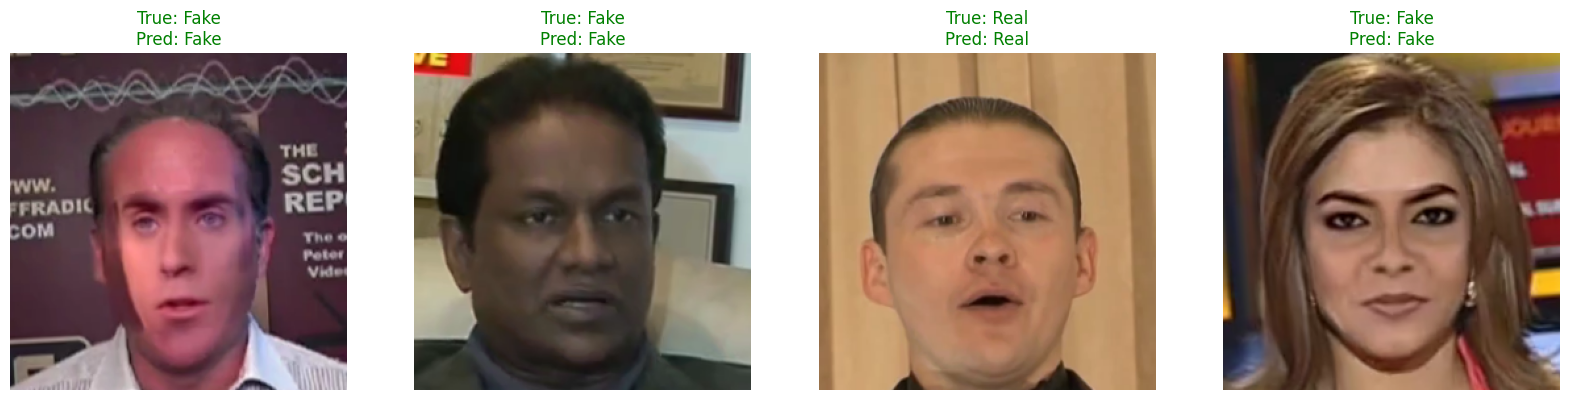

In [5]:
def imshow(img, title):
    img = img / 2 + 0.5 # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Get a random batch of test data
random.seed(42)
indices = random.sample(range(len(test_dataset_transformed)), k=4)
sample_data = [test_dataset_transformed[i] for i in indices]
raw_images = [test_dataset_raw[i]['image'] for i in indices]
sample_loader = DataLoader(sample_data, batch_size=4)

# Get predictions
dataiter = iter(sample_loader)
batch = next(dataiter)
inputs = batch['pixel_values']
labels = batch['label']
outputs = model(inputs)
predicted = (outputs > 0.5).squeeze()

# Plot the images with their predicted labels
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
label_map = {1: 'Real', 0: 'Fake'}

for i in range(4):
    ax = axes[i]
    ax.imshow(raw_images[i])
    true_label = label_map[labels[i].item()]
    pred_label = label_map[predicted[i].item()]
    ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=('green' if true_label == pred_label else 'red'))
    ax.axis('off')

plt.show()

## Project Summary

Congratulations! We have successfully built, trained, and evaluated a deepfake detection model.

We started by exploring the data, then trained a CNN model on it, and finally evaluated its performance on a held-out test set. 

### Future Improvements:
- **Use a more complex model**: A simple CNN is a good start, but more advanced architectures like ResNet or EfficientNet could provide better accuracy.
- **Train on more data**: We only used a subset of the data for quick training. Training on the full dataset for more epochs would likely improve performance.
- **Data Augmentation**: Applying random transformations (like rotations, flips, and color jitter) to the training data can help the model generalize better.
- **Video Analysis**: This model only processes images. A more advanced system could analyze video frames sequentially, possibly using an LSTM or Transformer model to capture temporal inconsistencies common in deepfakes.